# Import Librariies

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import os 
import random


import warnings
warnings.filterwarnings("ignore")

2025-07-01 21:21:49.979070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751404910.149156      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751404910.202765      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Get Data

In [3]:
image_folder_path = '/kaggle/input/teeth-dataset/Teeth_Dataset'
train_path = '/kaggle/input/teeth-dataset/Teeth_Dataset/Training'
test_path = '/kaggle/input/teeth-dataset/Teeth_Dataset/Testing'
validation_path = '/kaggle/input/teeth-dataset/Teeth_Dataset/Validation'

In [4]:
folders = list(os.listdir(image_folder_path))
print(folders)

['Validation', 'Training', 'Testing']


In [5]:
train_data = tf.keras.utils.image_dataset_from_directory(train_path)
test_data = tf.keras.utils.image_dataset_from_directory(test_path)
validation_data = tf.keras.utils.image_dataset_from_directory(validation_path)

Found 3087 files belonging to 7 classes.


I0000 00:00:1751404924.422320      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.


In [6]:
diseases = list(os.listdir(os.path.join(image_folder_path,'Testing')))
print(diseases)

['OC', 'CaS', 'OT', 'CoS', 'Gum', 'MC', 'OLP']


# Prepare Data

In [7]:
def plot_1_per_disease_in_folder(folder):
    fig, axes = plt.subplots(1, len(diseases), figsize=(10, 10))

    for ax, disease in zip(axes, diseases):
        diseases_dir = os.path.join(image_folder_path, folder, disease)
        valid_extensions = ('.jpeg', '.jpg', '.bmp', '.png')
        diseases_images = list(filter(lambda x: x.endswith(valid_extensions), os.listdir(diseases_dir)))

        if diseases_images:
            img_path = os.path.join(diseases_dir, random.choice(diseases_images))
            image = plt.imread(img_path)
            ax.imshow(image)
            ax.set_title(disease)
            ax.axis('off')
        else:
            ax.set_title(f'No images for {illness}')
            ax.axis('off')

    plt.tight_layout()
    plt.show()
    


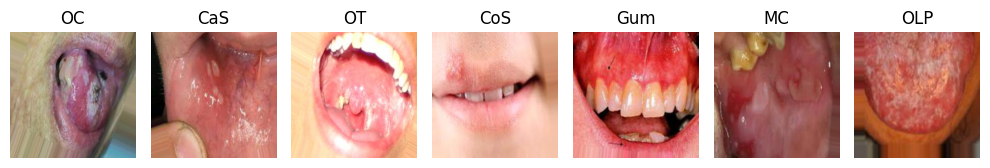

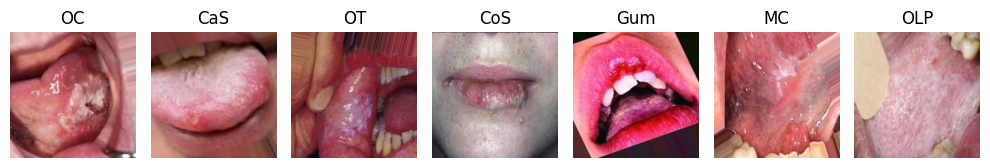

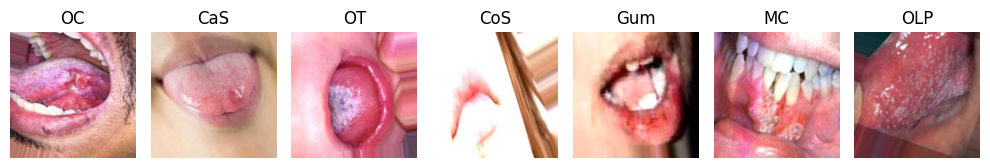

In [8]:

plot_1_per_disease_in_folder(folders[0] )

plot_1_per_disease_in_folder(folders[1] )

plot_1_per_disease_in_folder(folders[2] )


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_train_data_and_preprocess_it(train_data, target_size, batch_size):
    train_gen = ImageDataGenerator(
        rescale =  1/255.0,
        rotation_range = 20,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest',
    )

    train = train_gen.flow_from_directory(
        train_data,
        target_size = target_size,
        batch_size = batch_size,
        class_mode = 'categorical'
    )

    return train

def load_validation_data_and_preprocess_it(validation_data, target_size, batch_size):
    validation_gen = ImageDataGenerator(
        rescale =  1/255.0,
    )

    validation = validation_gen.flow_from_directory(
        validation_data,
        target_size = target_size,
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = False
    )

    return validation


In [10]:
train = load_train_data_and_preprocess_it(
                train_path,
                target_size=(150, 150),
                batch_size=32
                )

validation = load_validation_data_and_preprocess_it(
                validation_path,
                target_size=(150, 150),
                batch_size=32
                )

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


In [11]:
imgs, labels = next(train)
print(imgs.shape)
print(labels.shape)

(32, 150, 150, 3)
(32, 7)


In [13]:
print(train.class_indices)
print(validation.class_indices)

{'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}
{'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}


# Modeling

## Model 1

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

In [14]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

In [15]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [16]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,037,255 (72.62 MB)

 Trainable params: 19,037,255 (72.62 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:

history = model.fit(
    train,
    epochs = 50,
    validation_data=validation,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50


I0000 00:00:1751404934.063907     101 service.cc:148] XLA service 0x7b4cc8004680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751404934.064570     101 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751404934.377124     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/97 ━━━━━━━━━━━━━━━━━━━━ 9:41 6s/step - accuracy: 0.1875 - loss: 1.9288

I0000 00:00:1751404937.519805     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 365ms/step - accuracy: 0.1844 - loss: 2.0953 - val_accuracy: 0.2850 - val_loss: 1.7561 - learning_rate: 0.0010
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 201ms/step - accuracy: 0.2752 - loss: 1.8150 - val_accuracy: 0.3696 - val_loss: 1.6692 - learning_rate: 0.0010
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - accuracy: 0.3385 - loss: 1.7030 - val_accuracy: 0.4494 - val_loss: 1.4390 - learning_rate: 0.0010
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 195ms/step - accuracy: 0.3678 - loss: 1.5962 - val_accuracy: 0.4484 - val_loss: 1.4546 - learning_rate: 0.0010
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 199ms/step - accuracy: 0.4066 - loss: 1.5280 - val_accuracy: 0.5029 - val_loss: 1.3365 - learning_rate: 0.0010
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 201ms/step - accuracy: 0.4527 - loss: 1.4678 - val_accuracy: 0.5710 - val_loss: 1.2243 - learning_rate: 0.0010
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy: 0.4791 - loss: 1.3661 - val_

In [18]:

history = model.fit(
    train,
    epochs = 100,
    validation_data=validation,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 211ms/step - accuracy: 0.8157 - loss: 0.5034 - val_accuracy: 0.9183 - val_loss: 0.2318 - learning_rate: 0.0010
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 206ms/step - accuracy: 0.8317 - loss: 0.4660 - val_accuracy: 0.9086 - val_loss: 0.2648 - learning_rate: 0.0010
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 200ms/step - accuracy: 0.8295 - loss: 0.4800 - val_accuracy: 0.9241 - val_loss: 0.2331 - learning_rate: 0.0010
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 199ms/step - accuracy: 0.8598 - loss: 0.4211 - val_accuracy: 0.9484 - val_loss: 0.1678 - learning_rate: 0.0010
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 208ms/step - accuracy: 0.8616 - loss: 0.4208 - val_accuracy: 0.9494 - val_loss: 0.1413 - learning_rate: 0.0010
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - accuracy: 0.8526 - loss: 0.4275 - val_accuracy: 0.9416 - val_loss: 0.1656 - learning_rate: 0.0010
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 206ms/step - accuracy: 0.8482 - l

In [19]:
import os
from PIL import Image

bad_images = []

base_path = '/kaggle/input/teethdataset/Teeth_Dataset/Training'

for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.lower().endswith(('jpg', 'jpeg', 'png')):
            try:
                img = Image.open(os.path.join(root, file))
                img.verify()  # Will raise an exception if the image is corrupted
            except:
                bad_images.append(os.path.join(root, file))

print("Bad images:", bad_images)


Bad images: []


<Axes: >

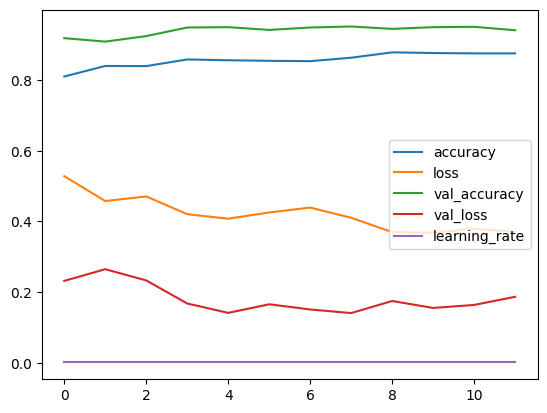

In [20]:

model_history = history.history
loss_acc_df = pd.DataFrame(model_history)
loss_acc_df.plot()

In [21]:
acc = model_history['accuracy']
val_acc = model_history['val_accuracy']
loss = model_history['loss']
val_loss = model_history['val_loss']

epochs = model.history.epoch

def plot_acc(acc, val_acc, epochs):
  plt.plot(epochs, acc, label='Training Accuracy')
  plt.plot(epochs, val_acc, label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc=0)
  plt.show()


def plot_loss(loss, val_loss, epochs):
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(loc=0)
  plt.show()



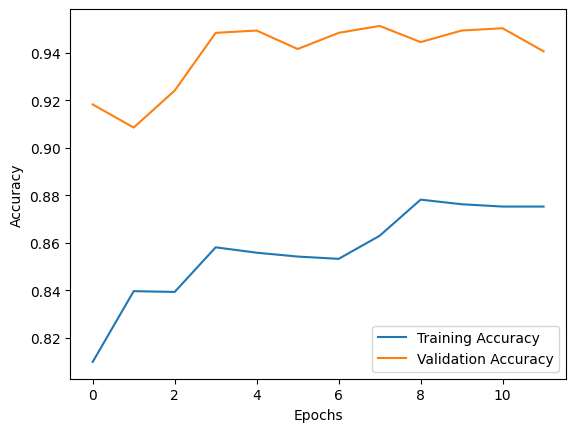

In [22]:
plot_acc(acc, val_acc, epochs)

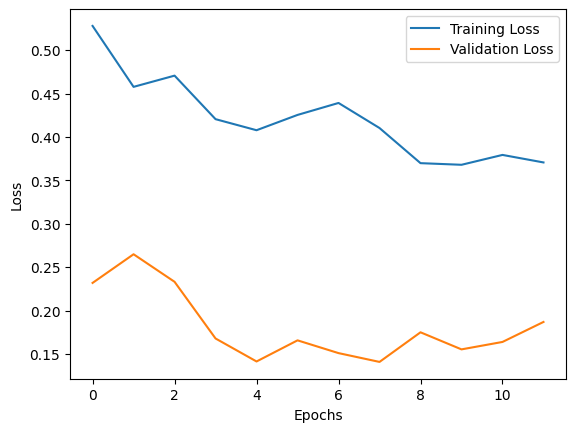

In [23]:
plot_loss(loss, val_loss, epochs)

In [24]:
test = load_validation_data_and_preprocess_it(
                test_path,
                target_size=(150, 150),
                batch_size=32
                )

Found 1028 images belonging to 7 classes.


In [25]:
test_loss, test_accuracy = model.evaluate(test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9535 - loss: 0.1220


In [26]:
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss: 0.14054395258426666
Test Accuracy: 0.9552529454231262


In [28]:
model.save('model1.keras')


## Model 2

In [32]:
from tensorflow.keras.applications import VGG16

input_shape = (150, 150, 3)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(7, activation='softmax')(x)

# Create final model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [33]:
history = model.fit(
    train,
    epochs=50,
    validation_data=validation,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 32s 256ms/step - accuracy: 0.2620 - loss: 1.9261 - val_accuracy: 0.6031 - val_loss: 1.2510 - learning_rate: 1.0000e-04
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - accuracy: 0.4788 - loss: 1.4175 - val_accuracy: 0.6148 - val_loss: 1.0835 - learning_rate: 1.0000e-04
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 208ms/step - accuracy: 0.5316 - loss: 1.2509 - val_accuracy: 0.6868 - val_loss: 0.9603 - learning_rate: 1.0000e-04
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 210ms/step - accuracy: 0.5775 - loss: 1.1392 - val_accuracy: 0.7276 - val_loss: 0.8615 - learning_rate: 1.0000e-04
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 207ms/step - accuracy: 0.6036 - loss: 1.0800 - val_accuracy: 0.7490 - val_loss: 0.8004 - learning_rate: 1.0000e-04
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 207ms/step - accuracy: 0.6408 - loss: 0.9964 - val_accuracy: 0.7695 - val_loss: 0.7423 - learning_rate: 1.0000e-04
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 209ms/step - acc

<Axes: >

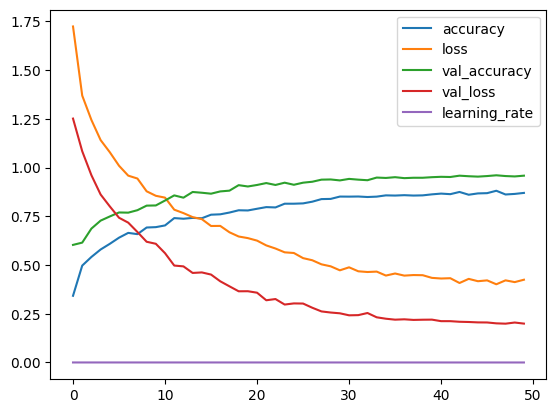

In [36]:

model_history = history.history
loss_acc_df = pd.DataFrame(model_history)
loss_acc_df.plot()

In [37]:
acc = model_history['accuracy']
val_acc = model_history['val_accuracy']
loss = model_history['loss']
val_loss = model_history['val_loss']

epochs = model.history.epoch

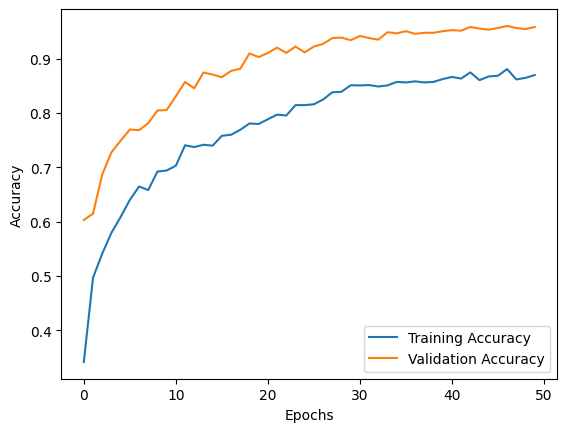

In [38]:
plot_acc(acc, val_acc, epochs)

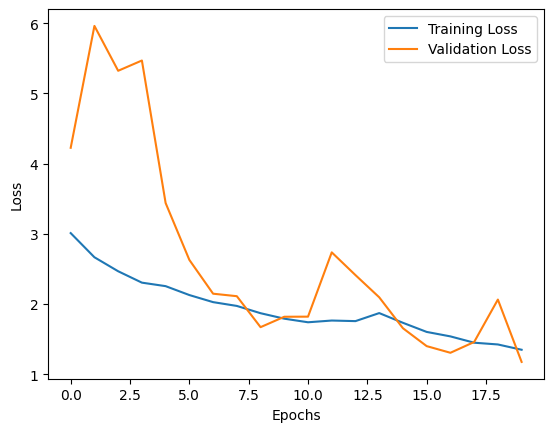

In [66]:
plot_loss(loss, val_loss, epochs)

In [45]:
test_loss, test_accuracy = model.evaluate(test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9677 - loss: 0.1633


In [46]:
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss: 0.20594118535518646
Test Accuracy: 0.9533073902130127


In [47]:
model.save('model2.keras')

## Model 3

In [60]:
    from tensorflow.keras.layers import BatchNormalization
    from tensorflow.keras.regularizers import l2


    model = Sequential()
    
    # Convolutional layers
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())   
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    
    # Flatten and Dense layers
    model.add(Flatten())
    
    model.add(Dense(units=256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
       
    model.add(Dense(units=7, activation='softmax')) 
    
   
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [61]:
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [62]:
history = model.fit(
    train,
    epochs=20,  
    validation_data=validation,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 293ms/step - accuracy: 0.2179 - loss: 3.2045 - val_accuracy: 0.1449 - val_loss: 4.2244 - learning_rate: 0.0010
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy: 0.3102 - loss: 2.7383 - val_accuracy: 0.1449 - val_loss: 5.9603 - learning_rate: 0.0010
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 210ms/step - accuracy: 0.3469 - loss: 2.5646 - val_accuracy: 0.1459 - val_loss: 5.3213 - learning_rate: 0.0010
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 196ms/step - accuracy: 0.3928 - loss: 2.3312 - val_accuracy: 0.1537 - val_loss: 5.4676 - learning_rate: 0.0010
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 23s 241ms/step - accuracy: 0.4231 - loss: 2.2672 - val_accuracy: 0.2597 - val_loss: 3.4376 - learning_rate: 0.0010
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 199ms/step - accuracy: 0.4453 - loss: 2.1621 - val_accuracy: 0.3521 - val_loss: 2.6275 - learning_rate: 0.0010
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 193ms/step - accuracy: 0.4884 - loss: 2.

In [67]:
history = model.fit(
    train,
    epochs=50,  
    validation_data=validation,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 198ms/step - accuracy: 0.7046 - loss: 1.3392 - val_accuracy: 0.6128 - val_loss: 1.7013 - learning_rate: 2.0000e-04
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 196ms/step - accuracy: 0.7129 - loss: 1.2888 - val_accuracy: 0.7354 - val_loss: 1.2398 - learning_rate: 2.0000e-04
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 193ms/step - accuracy: 0.7093 - loss: 1.3012 - val_accuracy: 0.8045 - val_loss: 1.0835 - learning_rate: 2.0000e-04
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 199ms/step - accuracy: 0.7408 - loss: 1.2001 - val_accuracy: 0.7695 - val_loss: 1.1476 - learning_rate: 2.0000e-04
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 197ms/step - accuracy: 0.7386 - loss: 1.1881 - val_accuracy: 0.7957 - val_loss: 1.0628 - learning_rate: 2.0000e-04
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 194ms/step - accuracy: 0.7523 - loss: 1.1513 - val_accuracy: 0.7529 - val_loss: 1.1530 - learning_rate: 2.0000e-04
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 194ms/step - acc

<Axes: >

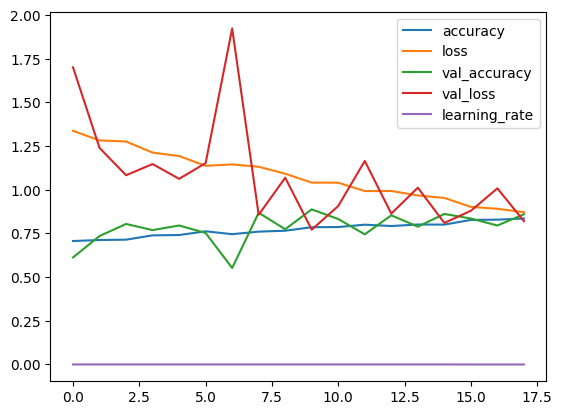

In [68]:

model_history = history.history
loss_acc_df = pd.DataFrame(model_history)
loss_acc_df.plot()

In [69]:
acc = model_history['accuracy']
val_acc = model_history['val_accuracy']
loss = model_history['loss']
val_loss = model_history['val_loss']

epochs = model.history.epoch

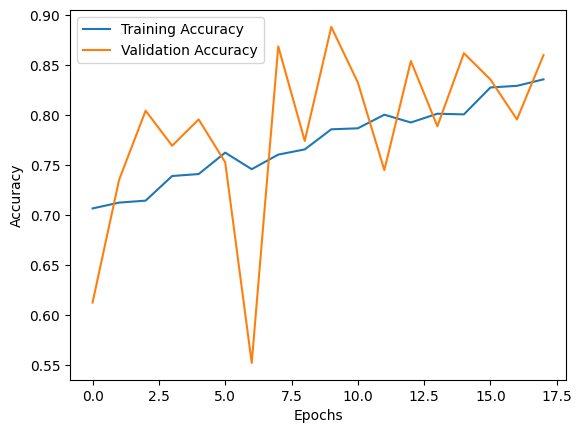

In [70]:
plot_acc(acc, val_acc, epochs)

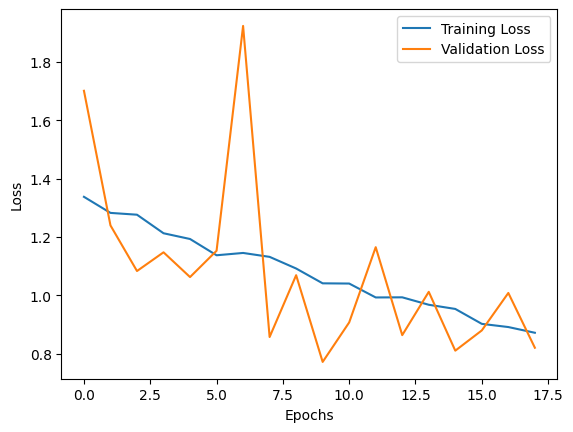

In [71]:
plot_loss(loss, val_loss, epochs)

In [72]:
test_loss, test_accuracy = model.evaluate(test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.9234 - loss: 0.6808


In [73]:
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss: 0.7516008019447327
Test Accuracy: 0.8998054265975952


In [74]:
model.save('model3.keras')

In [75]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 15, 15, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │       3,211,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 10,811,095 (41.24 MB)

 Trainable params: 3,603,207 (13.75 MB)

 Non-trainable params: 1,472 (5.75 KB)

 Optimizer params: 7,206,416 (27.49 MB)

# So the best Model is Model 1 with test Accuracy 95.5 